# Efektywna rekonstrukcja zdjęć kotów za pomocą wariacyjnych autoenkoderów z pomocą Self Supervised Learning

## 1. Wprowadzenie

### 1.1 Opis problemu

Celem projektu jest wytrenowanie modeli probabilistycznych autoenkoderów do rekonstrukcji obrazów kotów, które zostały częściowo zakryte maskami. Problem ten wpisuje się w obszar uczenia reprezentacji oraz probabilistycznych modeli grafowych. Zastosowane modele 

- VAE - baseline
- VQ-VAE
- VAE z priorem Tree-Vi 
- Attention-VAE

które mają nauczyć się skutecznego odwzorowywania struktury obrazu nawet w warunkach brakujących danych wejściowych.

Projekt opiera się na założeniu, że jakościowe reprezentacje ukryte, nauczone w sposób probabilistyczny, mogą posłużyć do efektywnej rekonstrukcji obrazów z brakującą informacją. 

W celu rozszerzenia projektu badamy, czy techniki uczenia samonadzorowanego, takie jak 

- BYOL
- Barlow Twins 
- SimCLR

mogą dodatkowo poprawić jakość enkoderów używanych w autoenkoderach. Zostaną one zastosowane z opcją zamrożenia wag wstępnie wytrenowanych enkoderów.

### 1.2 Opis danych wejściowych

Danymi wejściowymi są kolorowe obrazy kotów pochodzące z publicznego zbioru [Cats Image Dataset](https://www.kaggle.com/datasets/mahmudulhaqueshawon/cat-image/data). Obrazy przedstawiają pojedyncze twarze kotów oraz są w rozmiarze 3x64x64 pikseli.

Dane wejściowe zostaną poddane procesowi ETL oraz preprocesingu obejmującemu normalizację i przeskalowanie obrazów do jednolitego rozmiaru.

Podczas treningu wariacyjnych autoenkoderów przeprowadza się dynamiczną augmentację w postaci losowego nakładania masek o losowych rozmiarach w losowych miejscach, sparametryzowanych odpowiednimi ograniczeniami.

Dla zbioru validacyjnego i testowego obrazy posiadają wcześniej wygenerowane maski, aby uzyskać miarodajne wyniki.

w przypadku trenowania modeli SSL augumentacje są zależne od konkretnej metody oraz zostaną opisane w odpowiednich sekcjach.

### 1.3 Opis danych wyjściowych

Danymi wyjściowymi modeli są rekonstrukcje pełnych obrazów kotów bez maski z prawidłowym uzupełnieniem. Oczekujemy, że modele autoenkoderów nauczą się odwzorowywać brakujące fragmenty zdjęcia na podstawie informacji zawartych w reprezentacji ukrtytej.

### 1.4 Hipoteza badawcza

1. Zastosowanie probabilistycznych autoenkoderów umożliwia skuteczną rekonstrukcję obrazów kotów, które zostały częściowo zakryte maską.
2. Wstępne przetrenowanie enkoderów przy użyciu metod SSL dodatkowo poprawia jakość otrzymywanych rekonstrukcji.

Zakładamy, że różne podejścia do modelowania przestrzeni ukrytej (VQ, Tree priors) oraz różne techniki samonadzorowanego uczenia wpływają w zauważalny sposób na jakość reprezentacji i końcową skuteczność rekonstrukcji. Badanie to umożliwi określenie, który wariacyjny autoenkoder oraz technika SSL daje najlepsze rezultaty w kontekście rekonstrukcji obrazów kotów.

## 2. Opis wybranych modeli oraz metod

### 2.1 Wariacyjne autoenkodery

#### 2.1.1 VAE - Variational Autoencoder

Podstawowym modelem na którym oparte są pozostałe warianty jest klasyczny wariacyjny autoenkoder (VAE) pochodzący z pracy [Diederik P Kingma, Max Welling, 2013](https://arxiv.org/abs/1312.6114).

VAE to probabilistyczny autoenkoder, który zamiast kodować dane wejściowe do jednej reprezentacji wektorowej, uczy rozkład prawdopodobieństwa w przestrzeni latentnej. Podczas uczenia model maksymalizuje ELBO. Reprezentacja ukryta jest próbkowana z rozkładu normalnego (parametryzowanego przez enkoder), a dekoder rekonstruuje obraz.
<p align="center">
  <img src="./assets/vae-scheme.png" width="600">
</p>

<p align="center"><i>Schemat klasycznego VAE (źródło: <a href="https://medium.com/@jimwang3589/variational-autoencoder-vae-7609893c80f4">Medium</a>)</i></p>


Komponenty VAE:
- **Enkoder**: w naszym przypadku sieć konwolucyjna, której zadaniem jest zakodowanie danych wejściowych do skompresowanej reprezentacji, minimalizując utratę istotnej informacji z obrazu.

- **Warstwa probabilistyczna**: 
    - Przyjmuje reprezentację latentną z enkodera i przekształca ją do dwóch wektorów: średniej $\mu$ oraz logarytmu wariancji $\log(\sigma^2)$ za pomocą dwóch oddzielnych warstw liniowych.
    - Reparametryzacja ($\epsilon \sim \mathcal{N}(0, I) $): umożliwia propagację gradientu przez warstwę probabilistyczną $z = \mu + \sigma \cdot \epsilon$.
    - Zmienna latentna ($z$): próbkowana z rozkładu normalnego $\mathcal{N}(\mu, \sigma^2)$, z którego odtwarzane są dane przez dekoder.

- **Dekoder**: za pomocą transponowanych warstw konwolucyjnych rekonstruuje oryginalny obraz z wektora latentnego $z$.

- **Funkcja straty**: suma błędu rekonstrukcji (MSE) i dywergencji KL między rozkładem ukrytym, a prior'em będącym rozkładem normalnym $\mathcal{N}(0, I)$.


$$\mathcal{L}_{\text{VAE}} = \text{MSE}(x, \hat{x}) + D_{\text{KL}}\left( q(z|x) \,\|\, p(z) \right)$$

#### 2.1.2 VQ-VAE - Vector Quantized Variational Autoencoder

VQ-VAE to wariant VAE, w którym przestrzeń latentna jest dyskretna. Oznacza to, że składa się ze skończonego słownika - codebook wektorów. (przykładowo słownik 128 wektorów, każdy zawierający 64 ciągłych wartości) Enkoder przypisuje dane wejściowe do najbliższego wektora w słowniku, a dekoder rekonstruuje dane na podstawie tej zakodowanej reprezentacji. Uczenie odbywa się z użyciem specjalnej straty łączącej MSE i różnicę między zakodowaną reprezentacją a najbliższym wektorem ze słownika. [Aaron van den Oord, Oriol Vinyals, Koray Kavukcuoglu, 2017](https://arxiv.org/abs/1711.00937).

<p align="center">
  <img src="./assets/vqvae-scheme.png" width="700">
</p>

<p align="center"><i>Schemat VQVAE (źródło: <a href="https://arxiv.org/pdf/1711.00937">arxiv</a>)</i></p>


- **Enkoder:** mapuje wejściowy obraz $x$ na ciągłą reprezentację latentną $z_e(x) \in \mathbb{R}^D$.

- **Codebook (embedding space):** zawiera $K$ wektorów. Reprezentacja $z_e(x)$ jest kwantyzowana do najbliższego wektora $z_q(x) = e_k$

- **Dekoder:** odtwarza obraz $\hat{x}$ z zakodowanej i skwantyzowanej reprezentacji $z_q(x)$.

- **Funkcja Straty (Straight-through Estimator):** gradienty przechodzą bezpośrednio przez $z_q \rightarrow z_e$.


$$
\mathcal{L}_{\text{VQ-VAE}} = \underbrace{\| x - \hat{x} \|_2^2}_{\text{rekonstrukcja}} 
+ \underbrace{\| \text{sg}[z_e(x)] - e \|_2^2}_{\text{VQ loss}} 
+ \beta \underbrace{\| z_e(x) - \text{sg}[e] \|_2^2}_{\text{commitment loss}}
$$

Gdzie:
- $\text{sg}[\,\cdot\,]$ to operator *stop-gradient* (brak propagacji wstecz),
- $e$ to najbliższy wektor codebooku dla $z_e(x)$,
- $\beta$ to waga terminu commitment loss.


#### 2.1.3 VAE + Tree VI - Variational Autoencoder with Tree Variational Inference

### TODO Nikodem

#### 2.1.4 A-VAE / VAE-GAN  - Adversarial Variational Autoencoder

### TODO Daniel

### 2.2 Self Supervised Learning

#### 2.2.1 SimCLR - Simple Framework for Contrastive Learning of Visual Representations

### TODO Daniel

#### 2.2.2 BYOL - Bootstrap Your Own Latent

BYOL to metoda uczenia reprezentacji bez użycia etykiet ani kontrastowania negatywnych przykładów. Opiera się na architekturze dwóch
bliźniaczych sieci: online i target. Zadaniem metody jest nauczenie się reprezentacji poprzez minimalizację różnicy między reprezentacjami dwóch różnych augmentacji tego samego obrazu.


[Jean-Bastien Grill, Florian Strub, Florent Altché,... 2020](https://arxiv.org/abs/2006.07733).


<p align="center">
  <img src="./assets/byol-scheme.png" width="700">
</p>

<p align="center"><i>Schemat BYOL (źródło: <a href="https://arxiv.org/pdf/2006.07733">arxiv</a>)</i></p>

- **Dwa widoki obrazu**: $t(x)$ i $t'(x)$ (augmentacje)
- **Online network:** $f_\theta \rightarrow g_\theta \rightarrow q_\theta$
- **Target network:** $f_\xi \rightarrow g_\xi$
- gdzie $f$ to enkoder, $g$ to projektor, a $q$ to predyktor.
- **Funkcja straty:** minimalizuje odległość między predykcją z online i reprezentacją z target:
  
  $$
  \mathcal{L}_{\text{BYOL}} = \| q_\theta(z_\theta) - \text{sg}(z'_\xi) \|_2^2
  $$

Sieć target nie uczy się jak sieć online, jej wagi są aktualizowane na podsatwie wag sieci online z parametrem $\tau$.


#### 2.2.3 Barlow Twins

### TODO Nikodem

## 3. Opis eksperymentów

### 3.1 Jak przygotowano zbiór danych?

### TODO Nikodem
(np. transformacje, podział na zbiór treningowy / walidacyjny / testowy)

### 3.2 Zastosowane metryki

Jakość danych wyjściowych na zbiorze testowym będzie oceniana przy użyciu metryk porównujących obraz zrekonstruowany z obrazem oryginalnym, takich jak:

- PSNR (Peak Signal-to-Noise Ratio)
- SSIM (Structural Similarity Index)
- MSE (Mean Squared Error)
- Wizualna analiza jakości rekonstrukcji

Do wybierania najlepszego modelu spośród tych samych typów zostanie wybrany model z najniższą funkcją straty na zbiorze walidacyjnym.

## 4. Eksperymenty oraz wyniki

Wszystkie eksperymenty zostały przeprowadzone z wykorzystaniem tej samej architektury enkodera oraz dekodera, aby zapewnić uczciwe i miarodajne porównanie wyników różnych modeli.

#### Architektura enkodera:
- `input_dim`: 3 (obrazy RGB)
- `hidden_dim`: 128
- `residual_hiddens`: 64
- `num_residual_layers`: 1 lub 2

Enkoder składa się z trzech warstw konwolucyjnych z aktywacją ReLU, po których następuje jeden lub dwa bloki rezydualne. Dla wejścia o rozmiarze `batch × 3 × 64 × 64`, wyjściem jest tensor o kształcie `batch × 128 × 16 × 16`.

#### Architektura dekodera:
Dekoder odwzorowuje strukturę enkodera, z tą różnicą, że wykorzystuje **transponowane warstwy konwolucyjne** w miejsce standardowych konwolucji, umożliwiając rekonstrukcję obrazu do jego pierwotnych wymiarów (`64 × 64`). Liczba warstw oraz bloków rezydualnych pozostaje zgodna z konfiguracją enkodera.

In [1]:
from src.scripts.utils import get_test_loader, show_images, evaluate_model
import torch
from src.models.vae.VAE import VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataloader = get_test_loader()

d:\Projects\Inpainting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Copying dataset 'mahmudulhaqueshawon/cat-image' to data/raw_data...
[INFO] Dataset ready at data/raw_data


### 4.1 Część wariacyjnych autoenkoderów


#### 4.1.1 Baseline - VAE

Model VAE został wytrenowany dla różnych wartości hiperparametrów, zachowując stałą architekturę enkodera i dekodera (pomijając liczbę bloków rezydualnych). Wartości hiperparametrów obejmują:
- `latent_dim`: 256, 512, 1024, 2048
- `num_residual_layers`: 1, 2

stałymi hiperparametrami były:
- `batch_size`: 256
- `learning_rate`: 0.001
- `weight_decay`: 0.0001
- `epochs`: 30
- `mask_size`: 0.35


po uruchomieniu skryptu `src\scripts\reconstruction\run_vae_training.py` otrzymano 8 modeli VAE oraz wykresy zawierające przebieg funkcji straty, MSE, KL Divergence oraz liczbę aktywnych wymiarów w przestrzeni latentnej.

Dla 4 najlepszych modeli VAE uzyskano następujące wyniki

<div style="display: flex; justify-content: space-around; align-items: flex-start;">

  <div style="text-align: center; margin: 10px;">
    <img src="models/reconstruction/vae/metrics/vae_layers1_latent512_metrics.png" width="400"/>
    <p>VAE layers=1 latent_dim=512</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="models/reconstruction/vae/metrics/vae_layers2_latent512_metrics.png" width="400"/>
    <p>VAE layers=2 latent_dim=512</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="models/reconstruction/vae/metrics/vae_layers1_latent1024_metrics.png" width="400"/>
    <p>VAE layers=1 latent_dim=1024</p>
  </div>

  <div style="text-align: center; margin: 10px;">
    <img src="models/reconstruction/vae/metrics/vae_layers2_latent2048_metrics.png" width="400"/>
    <p>VAE layers=2 latent_dim=2048</p>
  </div>


</div>


| Model                               | Final Validation Loss | Final Active Dimensions |
|-------------------------------------|-----------------------|-------------------------|
| VAE (layers=2, latent_dim=2048)     | 173,283               | 1842                    |
| VAE (layers=1, latent_dim=512)      | 146,869               | 506                     |
| VAE (layers=1, latent_dim=1024)     | 143,198               | 992                     |
| VAE (layers=2, latent_dim=512)      | 137,267               | 503                     |
 

Najlepiej wypadającym modelem z tej grupy okazał się model o `latent_dim=512` i `num_residual_layers=2` na którym zostanie przeprowadzony test.

In [4]:
model = VAE(
    input_dim=3,
    hidden_dim=128,
    residual_hiddens=64,
    num_residual_layers=2,
    latent_dim=512,
)

model.load_state_dict(
    torch.load("models/reconstruction/vae/vae_layers2_latent512.pt", map_location=device)
)

evaluate_model(model, test_dataloader, device)

Average MSE: 0.0084
Average SSIM: 0.5531
Average PSNR: 21.2349


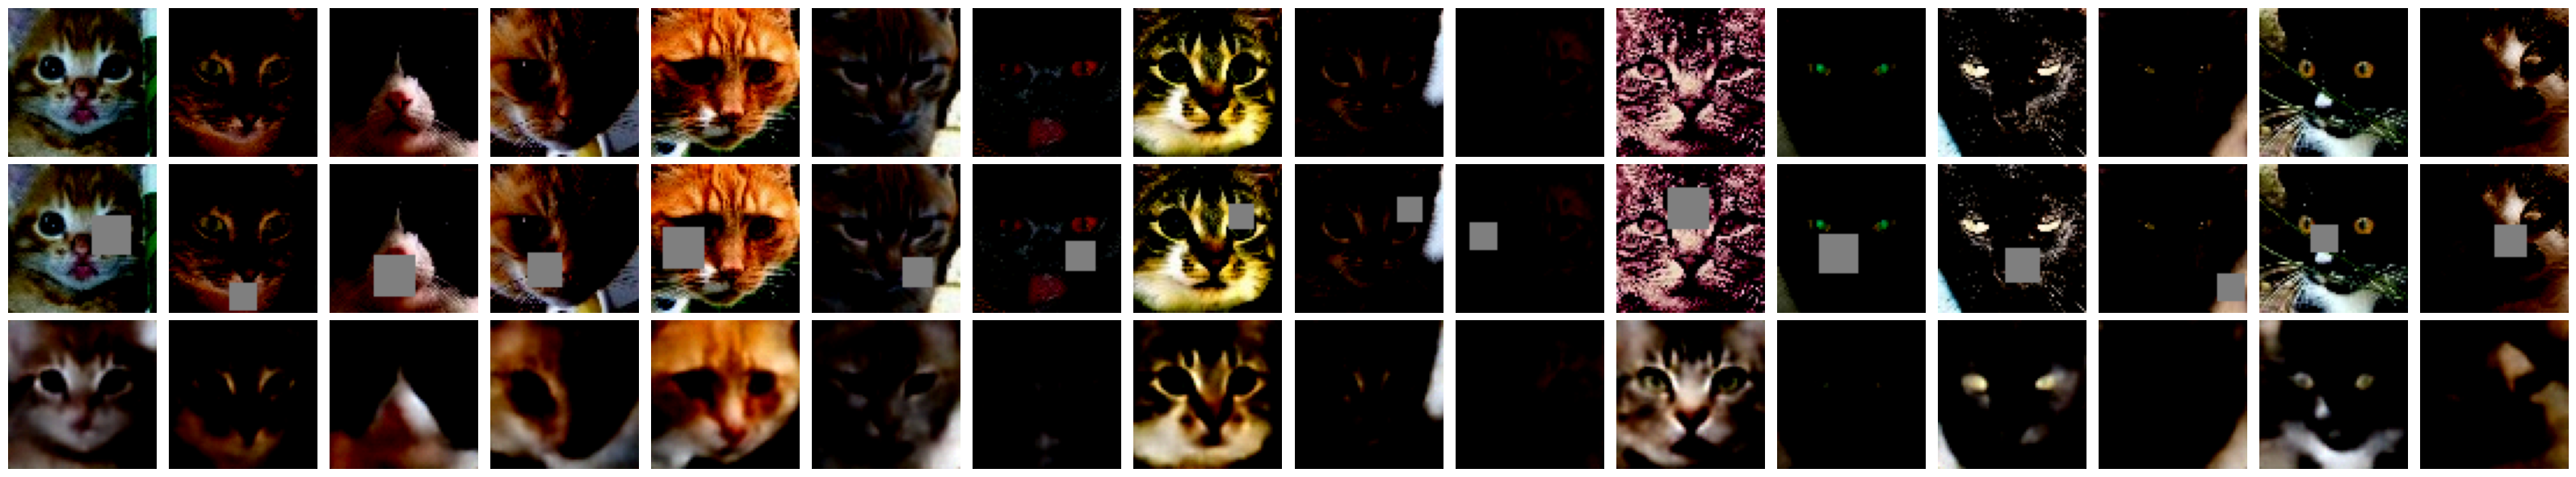

In [6]:
mask_img, clean_img = next(iter(test_dataloader))
mask_imgs = mask_img.to(device)
original_imgs = clean_img.to(device)

with torch.no_grad():
    reconstructed = model(mask_imgs)

show_images(original_imgs, mask_imgs, reconstructed["recon"], n=16)

#### 4.1.2 Wyniki VQ-VAE

Pamiętać o napisaniu Badane hiperparametry modeli i metod

#### 4.1.3 Wyniki VAE + Tree VI

### TODO Nikodem
Pamiętać o napisaniu Badane hiperparametry modeli i metod

#### 4.1.4 Wyniki A-VAE / VAE-GAN

### TODO Daniel
Pamiętać o napisaniu Badane hiperparametry modeli i metod

### 4.2 Część Self Supervised Learning + VAE

#### 4.2.1 Wyniki BYOL oraz BYOL + VAE

Pamiętać o napisaniu Badane hiperparametry modeli i metod

#### 4.2.2 Wyniki Barlow Twins oraz Barlow Twins + VAE

### TODO Nikodem
Pamiętać o napisaniu Badane hiperparametry modeli i metod

#### 4.2.3 Wyniki SIM CLR oraz SIM CLR + VAE

### TODO Daniel
Pamiętać o napisaniu Badane hiperparametry modeli i metod

## 5. Wnioski

### 5.1 Podsumowanie wyników

### 5.2 Analiza uzyskanych wyników w porównaniu z SOTA